In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xesmf as xe
%matplotlib inline
import cartopy
import cartopy.crs as ccrs
import matplotlib
from netCDF4 import Dataset
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma
import math
import xlrd
import os
import matplotlib.colors as colors
import scipy
from matplotlib import gridspec 

In [43]:
'''Define pimp generations and model names'''
# This cell lists the models involved in PMIP4 and PMIP3
pmip = {}
pmip['PMIP4'] = ['ACCESS-ESM1-5',
                 'AWI-ESM-1-1-LR',
                 'AWI-ESM-2-1-LR',
                 'CESM2',
                 'CNRM-CM6-1',
                 'EC-Earth3-LR',
                 'FGOALS-f3-L',
                 'FGOALS-g3',
                 'GISS-E2-1-G',
                 'HadGEM3-GC31-LL',
                 'INM-CM4-8',
                 'IPSL-CM6A-LR',
                 'MIROC-ES2L',
                 'MPI-ESM1-2-LR',
                 'MRI-ESM2-0',
                 'NESM3',
                 'NorESM1-F',
                 'NorESM2-LM',
                 'UofT-CCSM-4']
pmip['PMIP3'] = ['BCC-CSM1-1',
                 'CCSM4',
                 'CNRM-CM5',
                 'CSIRO-Mk3L-1-2',
                 'CSIRO-Mk3-6-0',
                 'EC-EARTH-2-2',
                 'FGOALS-g2',
                 'FGOALS-s2',
                 'GISS-E2-R',
                 'HadGEM2-CC',
                 'HadGEM2-ES',
                 'IPSL-CM5A-LR',
                 'MIROC-ESM',
                 'MPI-ESM-P',
                 'MRI-CGCM3']

In [ ]:
# EECO files (Lunt et al. 2020)

In [44]:
eeco_model = ['CESM1.2_9xCO2',
              'CESM1.2_6xCO2',
              'COSMOS_4xCO2',
              'GFDL_4xCO2',
              'GFDL_6xCO2',
              'INM-CM4-8_6xCO2',
              'NorESM1-f_4xCO2']
pi_model = ['CESM1.2_piControl',
            'CESM1.2_piControl',
            'COSMOS_piControl',
            'GFDL_piControl',
            'GFDL_piControl',
            'INM-CM4-8_piControl',
            'NorESM1-f_piControl']

In [2]:
pi1_model = ['CESM1.2_piControl','COSMOS_piControl','GFDL_piControl','INM-CM4-8_piControl','NorESM1-f_piControl']

In [50]:
# compute annual ave
for m in pi_model: 
    expt_file = Dataset('fig2data/eeco/%s-tos.nc'%m,'a')
    data = expt_file['tos'][:]
    average=np.average(data,axis=0)
    expt_file.createVariable('ann_ave','f',('latitude','longitude'))
    expt_file.variables['ann_ave'][:] = average  #remove this line if you don't want to save the resluts
    expt_file.close()    


In [3]:
lonS = np.arange(-179.5, 180., 1.0) 
latS = np.arange(-89.5, 90., 1.0) 
d = Dataset('eeco_pi.nc','w',format='NETCDF4') 
d.createDimension('lon',360)  
d.createDimension('lat',180)  
d.createVariable("lon",'f',("lon"))  
d.createVariable("lat",'f',("lat"))  
d.variables['lat'][:] = latS     
d.variables['lon'][:] = lonS   
d.close()

In [5]:
d = Dataset('eeco_pi.nc','a') 
grid_1x1 = xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90., 1.0)),
                         'lon': (['lon'], np.arange(-179.5, 180, 1.0))})
DATA=[]
for m in pi1_model:        
    expt_a_file = xr.open_dataset('fig2data/eeco/%s-tas.nc'%m,decode_times=False)
    expt_a = expt_a_file['ann_ave']
    this_regridder = xe.Regridder(expt_a_file,grid_1x1,'bilinear', reuse_weights=False,periodic=True) 
    var_1x1 = this_regridder(expt_a)               
    DATA.append(var_1x1)
    d.createVariable(m,'f',("lat",'lon'))  
    d.variables[m][:] = var_1x1     



In [6]:
data1 = np.array(DATA)
ave = var_1x1
ave.values = np.average(data1,axis=0)
d.createVariable('ave','f',("lat",'lon'))  #remove this line if you don't want to save the resluts
d.variables['ave'][:] = ave  #remove this line if you don't want to save the resluts
std = var_1x1
std.values = np.std(data1,axis=0)       
d.createVariable('std','f',("lat",'lon'))  #remove this line if you don't want to save the resluts
d.variables['std'][:] = std  #remove this line if you don't want to save the resluts
d.close()    

In [55]:
d = Dataset('eeco.nc','a') 
grid_1x1 = xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90., 1.0)),
                         'lon': (['lon'], np.arange(-179.5, 180, 1.0))})
DATA=[]
for i,m in enumerate(eeco_model):        
    expt_a_file = xr.open_dataset('fig2data/eeco/%s-tas.nc'%eeco_model[i],decode_times=False)
    expt_a = expt_a_file['ann_ave']
    expt_b_file = xr.open_dataset('fig2data/eeco/%s-tas.nc'%pi_model[i],decode_times=False)
    expt_b = expt_b_file['ann_ave']
    diff = expt_a - expt_b
    this_regridder = xe.Regridder(expt_a_file,grid_1x1,'bilinear', reuse_weights=False,periodic=True) 
    var_1x1 = this_regridder(diff)               
    DATA.append(var_1x1)
    d.createVariable(m,'f',("lat",'lon'))  
    d.variables[m][:] = var_1x1     


In [59]:
data1 = np.array(DATA)
ave = var_1x1
ave.values = np.average(data1,axis=0)
d.createVariable('ave','f',("lat",'lon'))  #remove this line if you don't want to save the resluts
d.variables['ave'][:] = ave  #remove this line if you don't want to save the resluts
std = var_1x1
std.values = np.std(data1,axis=0)       
d.createVariable('std','f',("lat",'lon'))  #remove this line if you don't want to save the resluts
d.variables['std'][:] = std  #remove this line if you don't want to save the resluts
d.close()    

In [ ]:
# compute eeco anomalies (Hollis et al. 2019)

# PI uses regridded MMM of pi1_model

In [25]:
# cal. proxy's coordinates 
pi_file = xr.open_dataset('fig2data/eeco_pi.nc',decode_times=False)
pi_value = pi_file['ave']-273.15

#fname1 = 'fig2fata/recons/eeco_sst_Hollis2019.csv'
df = pd.read_csv('eeco_sst_Hollis2019.csv',skipinitialspace=True,header=0)
v5 =df['v5']
v95=df['v95']
lat=df['latitude']
lon=df['longitude']
mean=df['Mean']
lat1=np.zeros(len(lat))
lon1=np.zeros(len(lon))
row1=np.zeros(len(lat))
col1=np.zeros(len(lon))
lse=np.zeros(len(v5))
hse=np.zeros(len(v95))
pi=np.zeros(len(lat))
anom=np.zeros(len(lon))
for i in range(len(lat1)): #This loop will round site-level coordinate to grid levels (1deg, 180x360), and calculate conrresponded row and col
    lse[i]=mean[i]-v5[i]
    hse[i]=v95[i]-mean[i]
    r1=lat[i]
    c1=lon[i]

    if r1<0:
        r=int(r1)-0.5
    if r1>=0:
        r=int(r1)+0.5

    if c1<0:
        c=int(c1)-0.5
    if c1>=0:
        c=int(c1)+0.5     
    lat1[i]=r
    lon1[i]=c  
    row1[i]=r+89.5
    col1[i]=c+179.5
    r1=row1[i]
    c1=col1[i]
    pi[i]=pi_value[int(r1)][int(c1)]
    anom[i]=mean[i]-pi[i]


In [26]:
d=pd.DataFrame({'latitude':lat,'longitude':lon,'mean':mean,'lse':lse,'hse':hse,'row':row1,'col':col1,'lat':lat1,'lon':lon1,'pi':pi,'anom':anom})




In [27]:
d

,latitude,longitude,mean,lse,hse,row,col,lat,lon,pi,anom
0,-65.330,1.280,12.867061,5.902445,4.163886,24.0,181.0,-65.5,1.5,-5.166229,18.033290
1,-63.310,136.000,33.370000,7.010000,6.830000,26.0,316.0,-63.5,136.5,-6.458038,39.828038
2,-62.720,82.790,12.288145,1.807712,1.728411,27.0,262.0,-62.5,82.5,-4.710114,16.998259
3,-52.220,166.190,30.070000,4.510000,4.100000,37.0,346.0,-52.5,166.5,7.978546,22.091454
4,-52.220,166.190,16.700372,2.159734,1.348249,37.0,346.0,-52.5,166.5,7.978546,8.721826
5,-45.320,170.830,18.774663,0.702960,0.768485,44.0,350.0,-45.5,170.5,10.985840,7.788824
6,-45.320,170.830,27.840000,4.050000,3.640000,44.0,350.0,-45.5,170.5,10.985840,16.854160
7,-45.320,170.830,34.460000,7.110000,8.960000,44.0,350.0,-45.5,170.5,10.985840,23.474160
8,-43.580,149.560,32.760000,6.860000,8.470000,46.0,329.0,-43.5,149.5,13.279114,19.480886
9,-43.060,172.610,27.100000,4.040000,3.530000,46.0,352.0,-43.5,172.5,12.013580,15.086420


In [28]:
d.to_csv('fig2data/recons/eeco_sst_Hollis2019.csv')

In [30]:
df = pd.read_csv('eeco_sat_Hollis2019.csv',skipinitialspace=True,header=0)
se =df['se']

lat=df['latitude']
lon=df['longitude']
mean=df['Mean']
lat1=np.zeros(len(lat))
lon1=np.zeros(len(lon))
row1=np.zeros(len(lat))
col1=np.zeros(len(lon))
pi=np.zeros(len(lat))
anom=np.zeros(len(lon))
for i in range(len(lat1)): #This loop will round site-level coordinate to grid levels (1deg, 180x360), and calculate conrresponded row and col
    r1=lat[i]
    c1=lon[i]

    if r1<0:
        r=int(r1)-0.5
    if r1>=0:
        r=int(r1)+0.5

    if c1<0:
        c=int(c1)-0.5
    if c1>=0:
        c=int(c1)+0.5     
    lat1[i]=r
    lon1[i]=c  
    row1[i]=r+89.5
    col1[i]=c+179.5
    r1=row1[i]
    c1=col1[i]
    pi[i]=pi_value[int(r1)][int(c1)]
    anom[i]=mean[i]-pi[i]

d=pd.DataFrame({'latitude':lat,'longitude':lon,'mean':mean,'se':se,'row':row1,'col':col1,'lat':lat1,'lon':lon1,'pi':pi,'anom':anom})




In [31]:
d

,latitude,longitude,mean,se,row,col,lat,lon,pi,anom
0,44.80,-107.10,43.1500,5.6000,134.0,72.0,44.5,-107.5,5.936127,37.213873
1,29.40,-103.20,27.4453,4.5107,119.0,76.0,29.5,-103.5,17.802216,9.643084
2,42.20,-108.50,27.1250,3.2500,132.0,71.0,42.5,-108.5,5.373688,21.751312
3,75.50,136.00,18.5000,4.3000,165.0,316.0,75.5,136.5,-16.703491,35.203491
4,78.80,-82.00,4.0000,5.5000,168.0,97.0,78.5,-82.5,-21.237228,25.237228
...,...,...,...,...,...,...,...,...,...,...
78,-63.18,135.59,18.4100,4.5000,26.0,315.0,-63.5,135.5,-6.440582,24.850582
79,-42.15,145.30,24.3000,3.3000,47.0,325.0,-42.5,145.5,13.047211,11.252789
80,-42.15,145.30,23.0000,3.3000,47.0,325.0,-42.5,145.5,13.047211,9.952789
81,-42.15,145.30,22.7000,1.8000,47.0,325.0,-42.5,145.5,13.047211,9.652789


In [32]:
d.to_csv('fig2data/recons/eeco_sat_Hollis2019.csv')

In [ ]:
# LGM files 

In [9]:
lgm_models=['AWIESM1',
            'AWIESM2',
            'CCSM4-UofT',
            'CESM1-2',
            'CESM2-1',
            'HadCM3-GLAC1D',
            'HadCM3-ICE6GC',
            'HadCM3-PMIP3',
            'iLOVECLIM1-1-1-GLAC-1D',
            'iLOVECLIM1-1-1-ICE-6G-C',
            'INM-CM4-8',
            'IPSLCM5A2',
            'MIROC-ES2L',
            'MPI-ESM1-2']

In [55]:
pd.DataFrame(lgm_models).to_csv('PMIP4_lgm.csv')

In [58]:
lonS = np.arange(-179.5, 180., 1.0) 
latS = np.arange(-89.5, 90., 1.0) 
d = Dataset('PMIP4_lgm.nc','w',format='NETCDF4') 
d.createDimension('lon',360)  
d.createDimension('lat',180)  
d.createVariable("lon",'f',("lon"))  
d.createVariable("lat",'f',("lat"))  
d.variables['lat'][:] = latS     
d.variables['lon'][:] = lonS   
d.close()

In [16]:
for m in lgm_models: 
    expt_file = Dataset('fig2data/lgm/PMIP4_tos_Omon_%s_lgm_monClim.nc'%m,'a')
    data = expt_file['tos'][:]
    average=np.average(data,axis=0)
    expt_file.createVariable('ann_ave','f',('lat','lon'))
    expt_file.variables['ann_ave'][:] = average  #remove this line if you don't want to save the resluts
    expt_file.close()    



In [59]:
d = Dataset('PMIP4_lgm.nc','a') 
grid_1x1 = xr.Dataset({'lat': (['lat'], np.arange(-89.5, 90., 1.0)),
                         'lon': (['lon'], np.arange(-179.5, 180, 1.0))})
DATA=[]
for m in lgm_models:        
    expt_a_file = xr.open_dataset('fig2data/lgm/PMIP4_tas_Amon_%s_piControl_monClim.nc'%m,decode_times=False)
    this_regridder1 = xe.Regridder(expt_a_file,grid_1x1,'bilinear', reuse_weights=False,periodic=True)
    expt_a = expt_a_file['ann_ave']
    a_var = this_regridder1(expt_a)
    expt_b_file = xr.open_dataset('fig2data/lgm/PMIP4_tas_Amon_%s_lgm_monClim.nc'%m,decode_times=False)
    this_regridder2 = xe.Regridder(expt_b_file,grid_1x1,'bilinear', reuse_weights=False,periodic=True) 
    expt_b = expt_b_file['ann_ave']
    b_var = this_regridder2(expt_b)
    var_1x1 = a_var - b_var               
    DATA.append(var_1x1)
    d.createVariable(m,'f',("lat",'lon'))  
    d.variables[m][:] = var_1x1     

In [60]:
data1 = np.array(DATA)
ave = var_1x1
ave.values = np.average(data1,axis=0)
d.createVariable('ave','f',("lat",'lon'))  #remove this line if you don't want to save the resluts
d.variables['ave'][:] = ave  #remove this line if you don't want to save the resluts
std = var_1x1
std.values = np.std(data1,axis=0)       
d.createVariable('std','f',("lat",'lon'))  #remove this line if you don't want to save the resluts
d.variables['std'][:] = std  #remove this line if you don't want to save the resluts
d.close()    

In [ ]:
# plotting

In [55]:
cmap=plt.get_cmap('bwr')
bounds1=[-60,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18,20,60]
bounds2=np.arange(-10,11,1)
norm1 = colors.BoundaryNorm(boundaries=bounds1, ncolors=256)
norm2 = colors.BoundaryNorm(boundaries=bounds2, ncolors=256)



In [34]:

def axplot(ax,m,modeldata,bounds1,norm1):
    projection = ccrs.Robinson()
    transform=ccrs.PlateCarree()
    ax.set_title(m,fontsize=15)
    ax.coastlines()
    ax.gridlines()
    fig=ax.contourf(modeldata.lon,modeldata.lat,modeldata,levels=bounds1,transform=transform,cmap=cmap,norm=norm1)
    cax1,kw1 = matplotlib.colorbar.make_axes([ax for ax in [ax]],location='bottom',pad=0.05,fraction=0.05)
    cb1=plt.colorbar(fig, cax=cax1, **kw1,extend='max')
    cb1label='Temperature anomaly (%sC)' %chr(176)
    cb1.set_label(cb1label,fontsize=12)
    cb1.ax.tick_params(labelsize=10)
    return fig

def plotdata(var,ax,m,data):
    fig=axplot(ax,m,modeldata)
    return fig

In [35]:
def axplot2(ax,title,name):
    M = pd.read_csv('fig2data/PMIP4_%s.csv'%name,header=0)
    models = M['0']
    data = xr.open_dataset('fig2data/PMIP4_%s.nc'%name,decode_times=False)
    lat=data['lat']
    ave=np.average(data['ave'],axis=1)
    plt.xlim([-90,90])
    plt.axhline(y=0,color='k')
    plt.plot(lat,ave,color='r',lw=2.5)
    plt.title(title,fontsize=15)
    for m in models:
        am = np.average(data[m],axis=1)
        plt.plot(lat,am,color='r',lw=1,alpha=0.3)
    plt.xlabel('latitude (%sN)'%chr(176),fontsize=12)
    plt.ylabel('Temperature anomaly (%sC)' %chr(176),fontsize=12)

In [60]:
def axploteeco(ax,title):
    M = pd.read_csv('fig2data/deepmip_eeco.csv',header=0)
    models = M['0']
    data = xr.open_dataset('fig2data/deepmip_eeco.nc',decode_times=False)
    lat=data['lat']
    ave=np.average(data['ave'],axis=1)
    plt.xlim([-90,90])
    plt.axhline(y=0,color='k')
    plt.plot(lat,ave,color='r',lw=2.5)
    plt.title(title,fontsize=15)
    for m in models:
        am = np.average(data[m],axis=1)
        plt.plot(lat,am,color='r',lw=1,alpha=0.3)
    plt.xlabel('latitude (%sN)'%chr(176),fontsize=12)
    plt.ylabel('Temperature anomaly (%sC)' %chr(176),fontsize=12)

In [36]:
lig = xr.open_dataset('fig2data/PMIP4_lig.nc',decode_times=False)
ligave = lig['ave']
liglat = lig['lat']
liglon = lig['lon']

In [37]:
mh = xr.open_dataset('fig2data/PMIP4_mh.nc',decode_times=False)
mhave = mh['ave']
mhlat = mh['lat']
mhlon = mh['lon']

In [38]:
lgm = xr.open_dataset('fig2data/PMIP4_lgm.nc',decode_times=False)
lgmave = lgm['ave']
lgmlat = lgm['lat']
lgmlon = lgm['lon']

In [50]:
eeco = xr.open_dataset('fig2data/deepmip_eeco.nc',decode_times=False)
eecoave = eeco['ave']
eecolat = eeco['lat']
eecolon = eeco['lon']

In [40]:
# PlioMIP2
mpwp = xr.open_dataset('fig2data/PlioMIP2.nc',decode_times=False)
mpwpave = mpwp['nearsurfacetemperaturemean_anomaly']

def axplot1(ax,m,modeldata,bounds1,norm1):
    projection = ccrs.Robinson()
    transform=ccrs.PlateCarree()
    ax.set_title(m,fontsize=15)
    ax.coastlines()
    ax.gridlines()
    fig=ax.contourf(modeldata.longitude,modeldata.latitude,modeldata,levels=bounds1,transform=transform,cmap=cmap,norm=norm1)
    cax1,kw1 = matplotlib.colorbar.make_axes([ax for ax in [ax]],location='bottom',pad=0.05,fraction=0.05)
    cb1=plt.colorbar(fig, cax=cax1, **kw1,extend='max')
    cb1label='Temperature anomaly (%sC)' %chr(176)
    cb1.set_label(cb1label,fontsize=12)
    cb1.ax.tick_params(labelsize=10)
    return fig

def plotdata1(var,ax,m,data):
    fig=axplot1(ax,m,modeldata)
    return fig

In [41]:
def axplot22(ax,title,data):
    lat=data.latitude
    ave=np.average(data,axis=1)
    plt.xlim([-90,90])
    plt.title(title,fontsize=15)
    plt.axhline(y=0,color='k')
    plt.plot(lat,ave,color='r',lw=2.5)
    #for m in models:
     #   am = np.average(data[m],axis=1)
     #   plt.plot(lat,am,color='r',lw=1,alpha=0.3)
    plt.xlabel('latitude (%sN)'%chr(176),fontsize=12)
    plt.ylabel('Temperature anomaly (%sC)' %chr(176),fontsize=12)

In [42]:
mpwp_model_data= pd.read_csv('fig2data/pliomip2_mpwp.csv',header=0)
mpwp_model= pd.read_csv('fig2data/PlioMIP2_model.csv',header=0)['0']

In [45]:
mh1_recons =pd.read_csv('fig2data/recons/mh_Bartlein2014.csv',skipinitialspace=True,header=0)
mh2_recons =pd.read_csv('fig2data/recons/mh_temp12k.csv',skipinitialspace=True,header=0)


In [ ]:
lgm1_recons =pd.read_csv('fig2data/recons/lgm_Cleator2019.csv',skipinitialspace=True,header=21)
lgm2_recons =pd.read_csv('fig2data/recons/lgm_Tierney2020.csv',skipinitialspace=True,header=0)

In [46]:
lig_recons = pd.read_csv('fig2data/recons/lig.csv',skipinitialspace=True,header=0)

In [47]:
mpwp_recons = pd.read_csv('fig2data/recons/mpwp.csv',skipinitialspace=True,header=0)

In [62]:
eeco1_recons = pd.read_csv('fig2data/recons/eeco_sat_Hollis2019.csv',skipinitialspace=True,header=0)
eeco2_recons = pd.read_csv('fig2data/recons/eeco_sst_Hollis2019.csv',skipinitialspace=True,header=0)

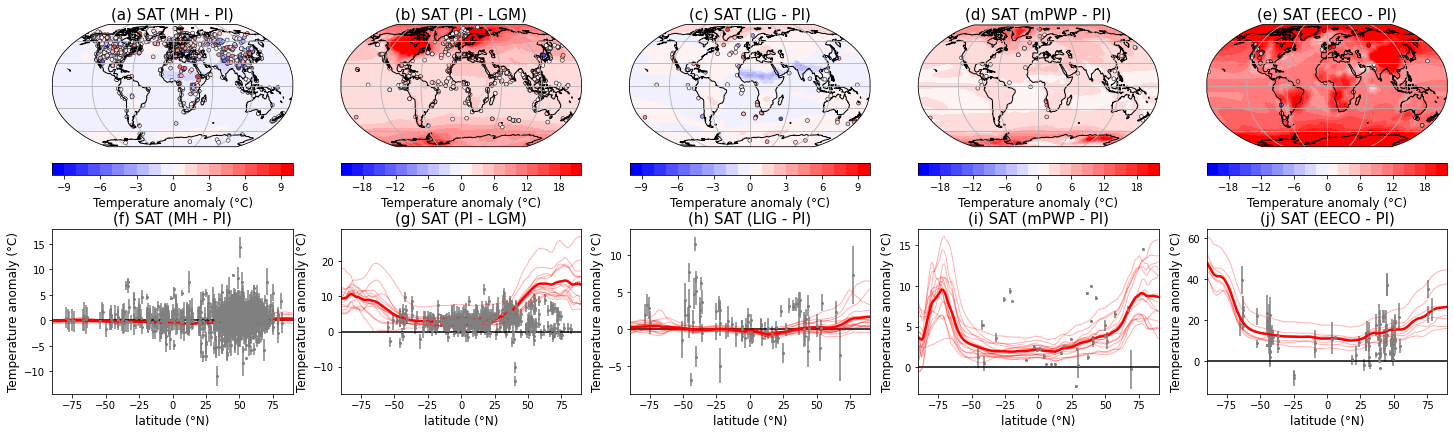

In [63]:
plt.figure(figsize=(25,10))
gs = gridspec.GridSpec(2,5,width_ratios=[1,1,1,1,1],height_ratios=[2,1]) 
#mh
ax0=plt.subplot(gs[0],projection= ccrs.Robinson())
axplot(ax0,'(a) SAT (MH - PI)',mhave,bounds2,norm2)
ax0.scatter(mh1_recons['lon'],mh1_recons['lat'],c=mh1_recons['mat_anm_mean'],marker='o',s=15,linewidths=0.5,edgecolors='k',cmap=cmap,transform=ccrs.PlateCarree(),norm=norm2)
ax0.scatter(mh2_recons['lon'],mh2_recons['lat'],c=mh2_recons['anom'],marker='o',s=15,linewidths=0.5,edgecolors='k',cmap=cmap,transform=ccrs.PlateCarree(),norm=norm2)
#lgm    
ax1=plt.subplot(gs[1],projection= ccrs.Robinson())
axplot(ax1,'(b) SAT (PI - LGM)',lgmave,bounds1,norm1)
#ax1.scatter(lgm1_recons['lon'],lgm1_recons['lat'],c=lgm1_recons['MAT'],marker='o',s=15,linewidths=0.5,edgecolors='k',cmap=cmap,transform=ccrs.PlateCarree(),norm=norm2)
ax1.scatter(lgm2_recons['Longitude'],lgm2_recons['Latitude'],c=0-lgm2_recons['Median'],marker='o',s=15,linewidths=0.5,edgecolors='k',cmap=cmap,transform=ccrs.PlateCarree(),norm=norm1)


#lig
ax2=plt.subplot(gs[2],projection= ccrs.Robinson())
axplot(ax2,'(c) SAT (LIG - PI)',ligave,bounds2,norm2)
ax2.scatter(lig_recons['Longitude'],lig_recons['Latitude'],c=lig_recons['Anom'],marker='o',s=15,linewidths=0.5,edgecolors='k',cmap=cmap,transform=ccrs.PlateCarree(),norm=norm2)

#mpwp
ax3=plt.subplot(gs[3],projection= ccrs.Robinson())
axplot1(ax3,'(d) SAT (mPWP - PI)',mpwpave,bounds1,norm1)
ax3.scatter(mpwp_recons['lon'],mpwp_recons['lat'],c=mpwp_recons['Anom'],marker='o',s=15,linewidths=0.5,edgecolors='k',cmap=cmap,transform=ccrs.PlateCarree(),norm=norm1)


#eeco
ax4=plt.subplot(gs[4],projection= ccrs.Robinson())
axplot(ax4,'(e) SAT (EECO - PI)',eecoave,bounds1,norm1)
ax4.scatter(eeco1_recons['lon'],eeco1_recons['lat'],c=eeco1_recons['anom'],marker='o',s=15,linewidths=0.5,edgecolors='k',cmap=cmap,transform=ccrs.PlateCarree(),norm=norm1)
ax4.scatter(eeco2_recons['lon'],eeco2_recons['lat'],c=eeco2_recons['anom'],marker='o',s=15,linewidths=0.5,edgecolors='k',cmap=cmap,transform=ccrs.PlateCarree(),norm=norm1)





#lat averaged
#MH
ax5=plt.subplot(gs[5])
mh1yerr=[ mh1_recons['mat_se_mean'],mh1_recons['mat_se_mean']]
ax5.errorbar(mh1_recons['lat'],mh1_recons['mat_anm_mean'], yerr=mh1yerr,marker='o',color='grey',ms=2,ls='none')
mh2yerr=[ mh2_recons['err'],mh2_recons['err']]
ax5.errorbar(mh2_recons['lat'],mh2_recons['anom'], yerr=mh2yerr,marker='o',color='grey',ms=2,ls='none')
axplot2(ax5,'(f) SAT (MH - PI)','mh')
#LGM
ax6=plt.subplot(gs[6])
#lgm1yerr=[ lgm1_recons['MAT_SD'],lgm1_recons['MAT_SD']]
#ax6.errorbar(lgm1_recons['lat'],0-lgm1_recons['MAT'], yerr=lgm1yerr,marker='o',color='grey',ms=2,ls='none')
lgm2yerr=[lgm2_recons['Lower2s']-lgm2_recons['Median'],lgm2_recons['Median']-lgm2_recons['Upper2s']]
ax6.errorbar(lgm2_recons['Latitude'],0-lgm2_recons['Median'], yerr=lgm2yerr,marker='o',color='grey',ms=2,ls='none')
axplot2(ax6,'(g) SAT (PI - LGM)','lgm')
#LIG
ax7=plt.subplot(gs[7])
ligyerr=[lig_recons['1SD'],lig_recons['1SD']]
ax7.errorbar(lig_recons['Latitude'],lig_recons['Anom'], yerr=ligyerr,marker='o',color='grey',ms=2,ls='none')
axplot2(ax7,'(h) SAT (LIG - PI)','lig')
#mpwp
ax8=plt.subplot(gs[8])
mpwpyerr=[mpwp_recons['std'],mpwp_recons['std']]
ax8.errorbar(mpwp_recons['lat'],mpwp_recons['Anom'], yerr=mpwpyerr,marker='o',color='grey',ms=2,ls='none')
axplot22(ax8,'(i) SAT (mPWP - PI)',mpwpave)
for m in mpwp_model:
    ax8.plot(mpwp_model_data['latitude'],mpwp_model_data[m],color='r',lw=1,alpha=0.3)
#eeco
ax9=plt.subplot(gs[9])
eeco1yerr=[eeco1_recons['se'],eeco1_recons['se']]
ax9.errorbar(eeco1_recons['latitude'],eeco1_recons['anom'], yerr=eeco1yerr,marker='o',color='grey',ms=2,ls='none')
eeco2yerr=[eeco2_recons['lse'],eeco2_recons['hse']]
ax9.errorbar(eeco2_recons['latitude'],eeco2_recons['anom'], yerr=eeco2yerr,marker='o',color='grey',ms=2,ls='none')
axploteeco(ax9,'(j) SAT (EECO - PI)')
